# Handwriting Recognition with Neural Networks
Basically in this notebook I am trying to teach a neural network to read—because apparently, even machines need to go to school now.

Took the MNIST dataset of handwritten digits (0–9), build a simple 2-layer neural network from scratch (no TensorFlow cheating here), and teach it to predict what digit it's seeing. Let's dive in!

## Imports and Dataset Loading
Starting with the usual imports: NumPy for math, pandas for data wrangling, and matplotlib for making things look pretty. Then we load our dataset like responsible data scientists.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
train_data = pd.read_csv('../datasets/mnist_train.csv')
test_data = pd.read_csv('../datasets/mnist_test.csv')

## Prepare and Shuffle Data
We convert our training dataset to a NumPy array and shuffle it to prevent any ordering bias.

In [3]:
data = np.array(train_data)
m, n = data.shape
np.random.shuffle(data)

## Extract the Dev Set (Validation)
We reserve the first 1000 examples to validate the model’s performance during training.

In [4]:
# Creating development (validation) and training sets
data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255   # Normalizing pixel values

## Prepare the Training Set
The rest of the dataset is used to train our neural net. We also normalize the pixel values to be between 0 and 1 for better learning performance.

In [5]:
# Creating Training Dataset from remaining
data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255   # Normalizing pixel values
_,m_train = X_train.shape
Y_train

array([1, 3, 5, ..., 4, 6, 3], shape=(59000,))

## Initialise Parameters
Here we initialise the required **weights** and **biases** that we'll use in our neural network. 
If you are unfamiliar with these terms, here is a short definition of these in accordance to my understanding:

**Weights (`W`):** Think of weights as the **"importance indicators"** for input features. In a layer, every connection from one neuron to the next has an associated weight. They decide **how strongly an input should influence the output**. If the input is pixels of a digit, weights decide which pixels matter more for recognizing "3" vs. "8".

**Biases (`b`):** Bias is like the **+1 friend** that shifts the activation function. Even if all inputs are zero, a neuron can still activate thanks to the bias. Helps the model fit better by **shifting** the activation up/down.

In [6]:
def init_params():
  # Subtract 0.5 from each para. to keep the range b/w -0.5 to +0.5
  W1 = np.random.rand(10, 784) - 0.5
  b1 = np.random.rand(10, 1) - 0.5
  W2 = np.random.rand(10, 10) - 0.5
  b2 = np.random.rand(10, 1) - 0.5
  return W1, b1, W2, b2

### Working of above function
#### Purpose:
- Randomly initialize the weights and biases.
- Subtracting `0.5` centers them around `0`, so they range from `-0.5` to `+0.5`.

#### Why center around 0?
- Helps break symmetry. If all weights were the same (say all 0), neurons would learn the same thing. That’s a no-go.

---

## Define Required Mathematical Functions
Now, let's start with defining the required functions to handle the math behind our neural network, which will later be used in training and testing the model. Let's understand each function one by one.

### 1. **ReLU(Z)** - Rectified Linear Unit
#### Mathematical Defintion
$$
\text{ReLU}(z) = \max(0, z)
$$
### Use of ReLU here
- Introduces **non-linearity**, essential for the network to learn complex patterns.
- Keeps things sparse — only positive values pass through.

### 2. **softmax(Z)** - Squishy Probability Layer
#### Mathematical Defintion
$$
\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{n} e^{z_j}}
$$
#### Use of softmax here
- Turns raw scores (`Z`) into **probabilities**.
- Ensures the output vector adds up to 1.
- Each value represents the **probability of the input being class i**.


### 3. **one_hot_encode(Y)** - Turn Labels into Vectors
#### Purpose
Convert labels like `5` → `[0 0 0 0 0 1 0 0 0 0]`  
Used for calculating loss with softmax output.

### 4. **derivative_ReLU(Z)** - Needed for backprop

#### Mathematical Definition
$$
\frac{d}{dz} \text{ReLU}(z) =
\begin{cases}
1 & \text{if } z > 0 \\
0 & \text{otherwise}
\end{cases}
$$

In [7]:
def ReLU(Z):
  return np.maximum(Z, 0)

def softmax(Z):
  A = np.exp(Z) / sum(np.exp(Z))
  return A

def one_hot_encode(Y):
  one_hot = np.zeros((Y.size, Y.max() + 1))
  one_hot[np.arange(Y.size), Y] = 1
  one_hot = one_hot.T
  return one_hot

def derivative_ReLU(Z):
  return Z > 0

## Core Training Loop - Forward Propagation, Backpropagation & Gradient Descent

This section defines the heart of how our neural network learns, let's understand each term one by one.
##### ***NOTE:** We are trying to build a simple neural network consisting of only 2 layers, not anything comples.*

### **1. Forward Propagation** - Computes predictions based on current weights.
`forward_propagation(W1, b1, W2, b2, X)`: **Let the data flow!**
#### Layer 1 (Input → Hidden):
$$
Z_1 = W_1 X + b_1
$$
$$
A_1 = \text{ReLU}(Z_1)
$$
#### Layer 2 (Hidden → Output):
$$
Z_2 = W_2 A_1 + b_2
$$
$$
A_2 = \text{softmax}(Z_2)
$$
#### Intuition:
- We apply matrix multiplication to simulate all neurons at once.
- Non-linearity with ReLU → then we calculate class probabilities via softmax.

### **2. Backpropagation** - Calculates the gradients of loss w.r.t. all parameters.
`back_propogation(...)`: **This is where we compute how wrong the model was and how to adjust the weights.**
- ***Note: `m` = number of examples (used for averaging gradients)***
### Working:
#### 1. Error at output (Softmax + Cross-Entropy derivative):
$$
dZ_2 = A_2 - Y_{\text{one-hot}}
$$

#### 2. Gradient for W2 and b2:
$$
dW_2 = \frac{1}{m} dZ_2 \cdot A_1^T
$$
$$
db_2 = \frac{1}{m} \sum dZ_2
$$

#### 3. Backprop error to hidden layer:
$$
dZ_1 = (W_2^T \cdot dZ_2) \circ \text{ReLU}'(Z_1)
$$

> '∘' means element-wise multiplication (Hadamard product)

#### 4. Gradient for W1 and b1:
$$
dW_1 = \frac{1}{m} dZ_1 \cdot X^T
$$
$$
db_1 = \frac{1}{m} \sum dZ_1
$$
  
### **3. Parameter Update** adjusts weights and biases using those gradients to reduce error over time.
`update_parameters(...)`: **Gradient Descent Happens**

#### Formula:
$$
W = W - \alpha \cdot \frac{\partial \mathcal{L}}{\partial W}
$$

Where:
- α = learning rate (how fast you wanna move)
- L = loss function

Repeat this process until weights are Gucci™ (well-trained).

In [8]:
def forward_propogation(W1, b1, W2, b2, X):     # X is A0
  Z1 = W1.dot(X) + b1
  A1 = ReLU(Z1)
  Z2 = W2.dot(A1) + b2
  A2 = softmax(Z2)
  return Z1, A1, Z2, A2

def back_propogation(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot_encode(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * derivative_ReLU(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
  W1 = W1 - alpha * dW1
  b1 = b1 - alpha * db1
  W2 = W2 - alpha * dW2
  b2 = b2 - alpha * db2
  return W1, b1, W2, b2

## Summary Table of Math Used

| Function              | Purpose                                  | Core Math Used                                         |
|-----------------------|-------------------------------------------|--------------------------------------------------------|
| `init_params()`       | Initialize weights/biases                 | Random values in range [-0.5, 0.5]                     |
| `ReLU()`              | Non-linearity                             | \(\max(0, z)\)                                         |
| `softmax()`           | Probabilistic output                      | \(\frac{e^z}{\sum e^z}\)                               |
| `forward_prop...()`   | Feed input through network                | \(Z = WX + b\), apply activation                      |
| `one_hot_encode()`    | Label encoding                            | Matrix with 1 in label position                       |
| `derivative_ReLU()`   | Backprop chain                            | 1 if z > 0 else 0                                     |
| `back_prop...()`      | Compute gradients                         | Chain rule, dot products, element-wise ops            |
| `update_parameters()` | Improve weights                           | Gradient Descent: \(W = W - \alpha dW\)               |

---

## Training the Neural Network with Gradient Descent

This section defines the core training loop using **gradient descent**, it utilizes the previously defined mathematical functions all together to helps our neural network *learn* by reducing prediction errors step-by-step.

We also define two helper functions:
- `get_predictions()`: returns the predicted digit (index of max probability).
- `get_accuracy()`: compares predictions with true labels and calculates the accuracy.

In [9]:
# Define Gradient Descent & it's required functions
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_propogation(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = back_propogation(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2

## Training the Model

Now that all the functions are defined, let's train our neural network using the **gradient descent** loop.

We're passing:
- `X_train`, `Y_train`: our training dataset (normalized).
- `0.1`: the learning rate (α), a crucial hyperparameter that controls how big our parameter updates are.
- `500`: the number of training iterations/epochs.

This will return the trained weights and biases: `W1`, `b1`, `W2`, and `b2`, which are now infused with pure digit-recognizing intelligence (aka learned patterns).

In [10]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.1, 500)

Iteration:  0
[4 4 2 ... 4 4 4] [1 3 5 ... 4 6 3]
0.08767796610169491
Iteration:  10
[4 9 4 ... 3 1 3] [1 3 5 ... 4 6 3]
0.1706949152542373
Iteration:  20
[6 9 6 ... 3 4 3] [1 3 5 ... 4 6 3]
0.2475593220338983
Iteration:  30
[6 9 8 ... 3 4 3] [1 3 5 ... 4 6 3]
0.32113559322033897
Iteration:  40
[6 9 8 ... 9 4 3] [1 3 5 ... 4 6 3]
0.384271186440678
Iteration:  50
[1 9 8 ... 9 6 3] [1 3 5 ... 4 6 3]
0.4448305084745763
Iteration:  60
[1 9 8 ... 9 6 3] [1 3 5 ... 4 6 3]
0.5029152542372881
Iteration:  70
[1 9 8 ... 9 8 3] [1 3 5 ... 4 6 3]
0.5465593220338983
Iteration:  80
[1 9 8 ... 9 8 3] [1 3 5 ... 4 6 3]
0.5834745762711865
Iteration:  90
[1 0 8 ... 9 8 3] [1 3 5 ... 4 6 3]
0.6132033898305085
Iteration:  100
[1 0 8 ... 9 8 3] [1 3 5 ... 4 6 3]
0.6402203389830509
Iteration:  110
[1 3 8 ... 9 8 3] [1 3 5 ... 4 6 3]
0.6626949152542373
Iteration:  120
[1 3 8 ... 9 8 3] [1 3 5 ... 4 6 3]
0.6824915254237288
Iteration:  130
[1 3 8 ... 9 8 3] [1 3 5 ... 4 6 3]
0.6990508474576271
Iteration:  140


## Making Predictions on Training Data

Now that the model is trained, we define two utility functions:

1. **`make_prediction(X, W1, b1, W2, b2)`** – Given input `X`, this returns the model’s predicted digit.
2. **`test_predictions(index, W1, b1, W2, b2)`** – This function:
   - Grabs the image at a specific index from the training set.
   - Runs it through the model.
   - Displays the actual label, predicted label, and visualizes the digit using `matplotlib`.

This is basically a mini "exam" for the model to show off what it has learned.

In [11]:
def make_prediction(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_propogation(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_predictions(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_prediction(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Label:", label)
    print("Prediction:", prediction)

    current_image = current_image.reshape((28,28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation="nearest")
    plt.show()

## Testing Predictions on a Few Training Examples

Let’s try our trained neural net on a few real handwritten digits from the training set and see what it thinks. We’ll look at the image and compare the predicted digit with the actual label.

(If it gets them right — flex. If not, well... backprop has entered the chat.)

Label: 1
Prediction: [1]


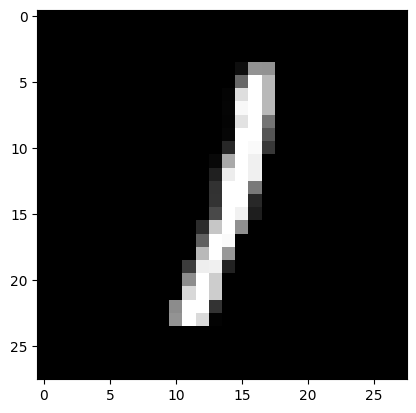

Label: 3
Prediction: [3]


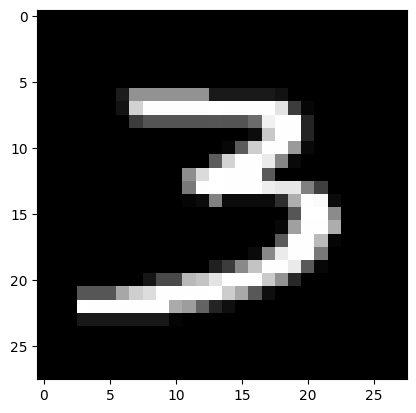

Label: 5
Prediction: [8]


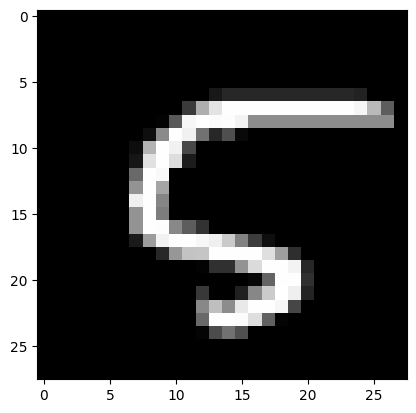

Label: 7
Prediction: [3]


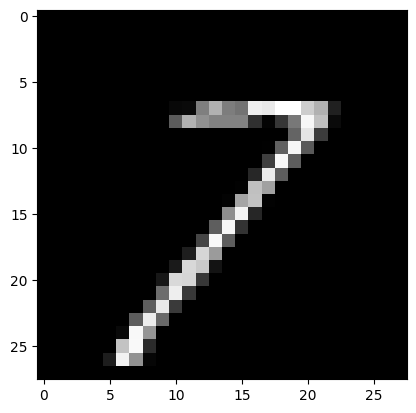

In [12]:
test_predictions(0, W1, b1, W2, b2)
test_predictions(1, W1, b1, W2, b2)
test_predictions(2, W1, b1, W2, b2)
test_predictions(3, W1, b1, W2, b2)

## Evaluating Model Accuracy on the Development Set
This cell evaluates the accuracy of the model on the development (dev) set that we kept seperately from the start. The predictions for the dev set are generated using the make_prediction function, and the accuracy is then calculated by comparing the predicted labels (dev_predictions) with the true labels (Y_dev).

In [13]:
dev_predictions = make_prediction(X_dev, W1, b1, W2, b2)
get_accuracy(dev_predictions, Y_dev)

[3 0 6 0 2 4 3 3 2 9 3 1 9 8 9 6 0 9 4 7 2 9 8 9 5 7 6 3 0 3 6 3 5 6 2 0 6
 0 1 9 7 0 4 7 8 3 3 4 9 5 4 0 8 8 1 4 9 6 8 3 3 4 7 9 9 2 0 9 9 7 9 0 1 0
 0 4 7 1 4 4 1 0 6 2 3 5 7 9 3 2 9 9 8 0 2 3 2 1 1 9 0 3 3 3 3 0 8 6 9 1 0
 3 8 7 8 8 1 7 5 2 1 9 2 5 8 7 0 7 8 8 1 4 1 5 3 4 2 1 3 5 9 9 1 6 6 3 3 7
 4 6 3 1 5 5 0 1 2 8 2 2 7 4 8 4 7 8 7 1 9 0 0 8 4 4 7 2 1 9 4 5 6 3 5 7 1
 6 5 9 6 3 6 7 3 7 6 4 5 0 9 1 3 5 7 1 1 5 5 6 0 5 6 2 4 1 4 1 3 4 3 8 0 4
 8 4 6 1 4 4 2 1 8 3 8 6 1 7 7 5 7 1 1 7 3 1 7 8 7 9 1 8 4 0 8 4 6 6 7 7 0
 3 9 1 4 4 3 4 5 3 3 3 9 9 7 0 4 9 7 0 1 8 5 6 4 4 1 4 9 0 1 2 8 1 4 1 2 2
 7 0 1 8 4 7 5 2 9 8 3 2 4 5 7 0 7 0 5 2 6 8 6 6 7 4 8 9 8 5 7 3 8 3 2 9 1
 5 5 9 0 4 1 2 7 2 8 9 9 4 2 8 7 7 7 7 7 3 1 1 6 2 3 9 3 1 1 2 7 2 6 7 2 8
 7 0 7 8 6 9 2 3 1 8 1 0 7 6 5 5 6 8 7 4 1 2 7 2 3 8 5 3 1 2 3 7 2 5 6 0 8
 8 6 8 5 0 1 8 9 3 4 1 4 0 3 1 4 0 8 1 4 6 1 0 6 2 0 6 6 0 1 3 4 1 9 8 4 2
 5 5 6 2 7 0 0 1 5 0 7 4 1 6 0 2 1 2 2 6 0 1 8 0 8 2 8 5 6 4 3 4 9 6 2 9 4
 2 8 9 7 1 1 0 2 5 8 0 6 

np.float64(0.854)

## Accuracy on dev set is **85.4%**